In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from dash import Dash, dcc, html, Input, Output
!pip install "dash[cloud]"



In [31]:
# --------------------------------------
# Load dataset
# --------------------------------------
df = pd.read_excel("Confectionary [4564] (3).xlsx")
df_backup = df.copy()

# Inspect
print(df.head())
print(df.info())
print(df.isnull().sum())

        Date Country(UK) Confectionary  Units Sold  Cost(£)  Profit(£)  \
0 2002-11-11     England       Biscuit      1118.0   2459.6     3130.4   
1 2002-07-05     England       Biscuit       708.0   1557.6     1982.4   
2 2001-10-31     England       Biscuit      1269.0   2791.8     3553.2   
3 2004-09-13     England       Biscuit      1631.0   3588.2     4566.8   
4 2004-03-10     England       Biscuit      2240.0   4928.0     6272.0   

   Revenue(£)  
0    749954.4  
1    300758.4  
2    966216.6  
3   1596096.6  
4   3010560.0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1001 entries, 0 to 1000
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           1001 non-null   datetime64[ns]
 1   Country(UK)    1001 non-null   object        
 2   Confectionary  1001 non-null   object        
 3   Units Sold     996 non-null    float64       
 4   Cost(£)        992 non-null    float64    

In [32]:
# --------------------------------------
# Clean and preprocess
# --------------------------------------
df.columns = [c.strip() for c in df.columns]
df.rename(columns={"Country(UK)": "Region"}, inplace=True)

# Correcting the confectionary name
df['Confectionary'] = df['Confectionary'].str.title().str.strip()
df['Confectionary'] = df['Confectionary'].replace({
    'Choclate Chunk': 'Chocolate Chunk',
    'Caramel nut': 'Caramel Nut',
    'Caramel Nut': 'Caramel Nut'
})

print("Unique Confectionary Types:", df['Confectionary'].unique())

# Parse date
df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
df["Year"] = df["Date"].dt.year
df["Month"] = df["Date"].dt.month
df["YearMonth"] = df["Date"].dt.to_period("M").astype(str)

# Convert numeric
for col in ["Units Sold", "Cost(£)", "Profit(£)", "Revenue(£)"]:
    df[col] = pd.to_numeric(df[col], errors="coerce")

# Handle nulls
df = df.dropna(subset=["Date", "Region", "Confectionary"])
for col in ["Units Sold", "Cost(£)", "Profit(£)", "Revenue(£)"]:
    df[col] = df[col].fillna(df[col].median())

# Derived metrics
df["Margin"] = np.where(df["Revenue(£)"] > 0,
                        df["Profit(£)"] / df["Revenue(£)"],
                        np.nan)

df["Unit_Price"] = np.where(df["Units Sold"] > 0,
                            df["Revenue(£)"] / df["Units Sold"],
                            np.nan)

df["Unit_Cost"] = np.where(df["Units Sold"] > 0,
                           df["Cost(£)"] / df["Units Sold"],
                           np.nan)

df["Unit_Profit"] = np.where(df["Units Sold"] > 0,
                             df["Profit(£)"] / df["Units Sold"],
                             np.nan)

Unique Confectionary Types: ['Biscuit' 'Biscuit Nut' 'Chocolate Chunk' 'Caramel Nut' 'Caramel' 'Plain']


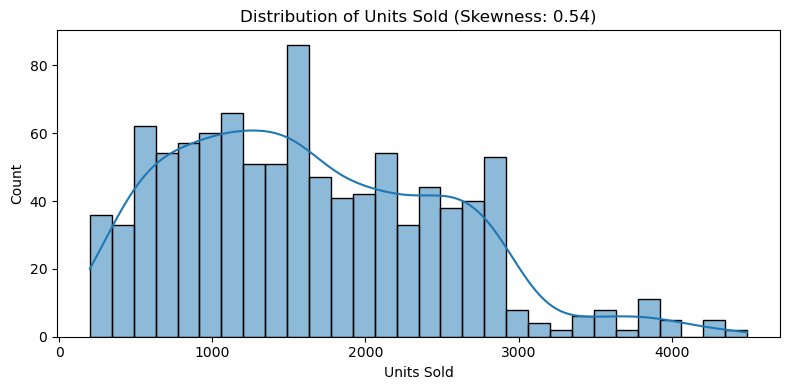

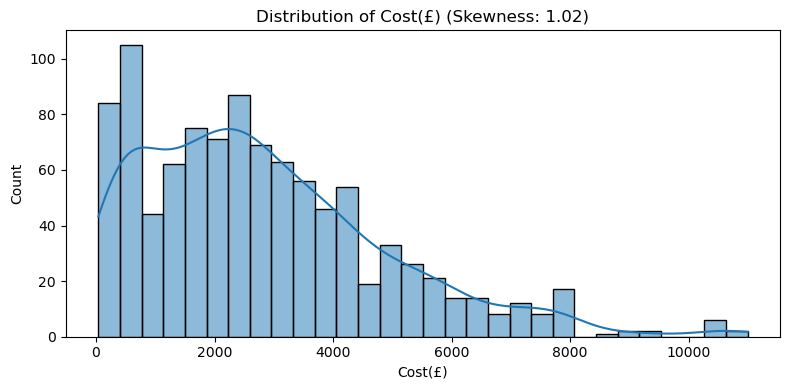

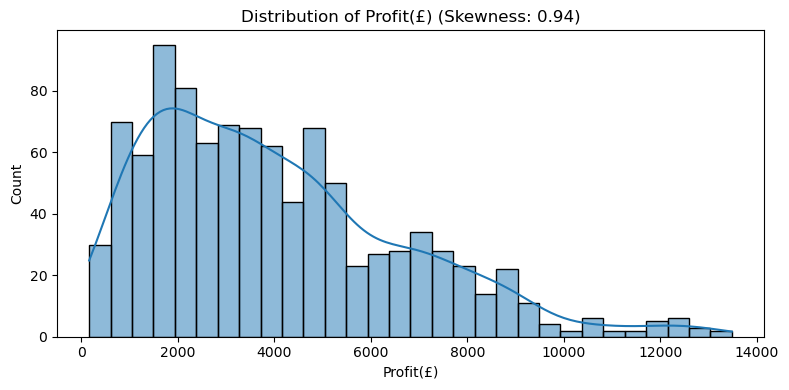

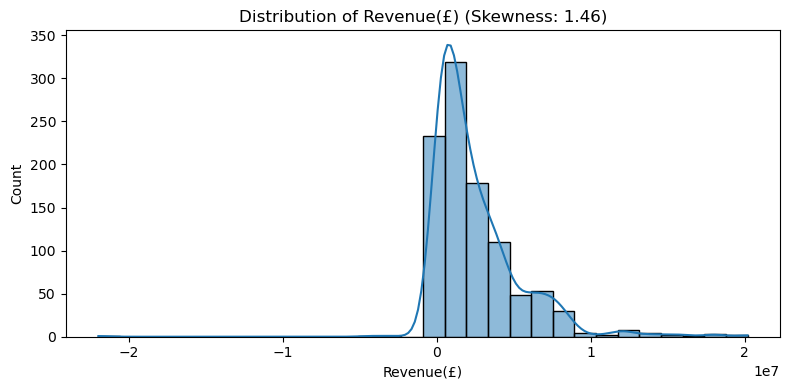

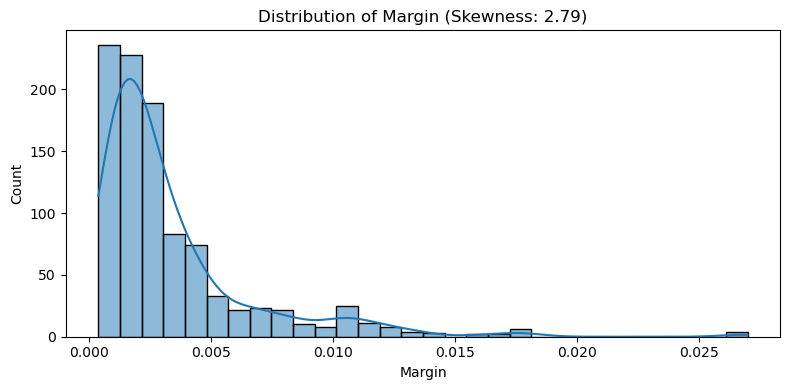

In [33]:
#  SKEWNESS PLOTS (5 Variables)

skew_cols = ["Units Sold", "Cost(£)", "Profit(£)", "Revenue(£)", "Margin"]

for col in skew_cols:
    plt.figure(figsize=(8, 4))
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f"Distribution of {col} (Skewness: {df[col].skew():.2f})")
    plt.tight_layout()
    plt.show()

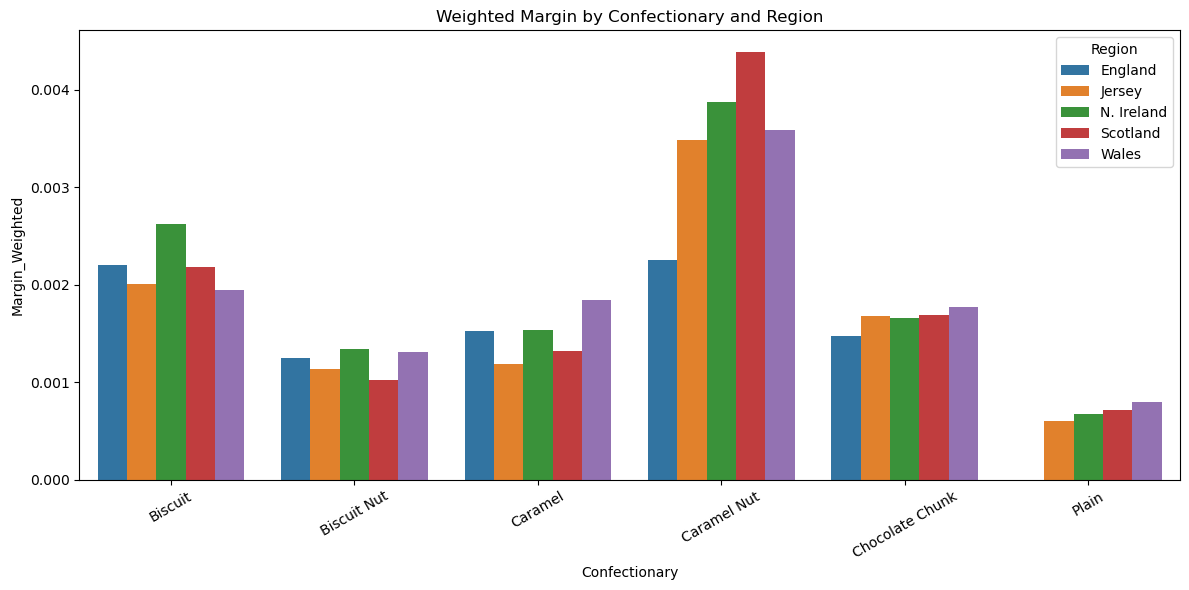

In [34]:
# ==========================================================
#  5 STATIC VISUALIZATIONS
# ==========================================================

# 1. Weighted Margin Bar Plot
agg = df.groupby(["Region", "Confectionary"]).agg(
    Revenue_Total=("Revenue(£)", "sum"),
    Profit_Total=("Profit(£)", "sum")
).reset_index()

agg["Margin_Weighted"] = agg["Profit_Total"] / agg["Revenue_Total"]

plt.figure(figsize=(12, 6))
sns.barplot(
    data=agg,
    x="Confectionary",
    y="Margin_Weighted",
    hue="Region"
)
plt.title("Weighted Margin by Confectionary and Region")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

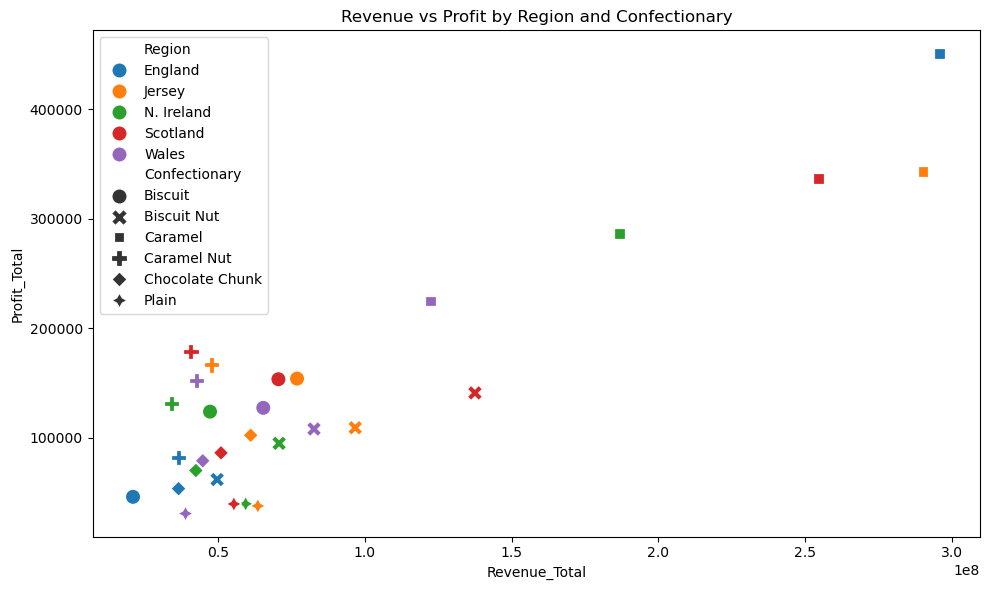

In [35]:
# 2. Revenue vs Profit Scatter Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=agg,
    x="Revenue_Total",
    y="Profit_Total",
    hue="Region",
    style="Confectionary",
    s=120
)
plt.title("Revenue vs Profit by Region and Confectionary")
plt.tight_layout()
plt.show()

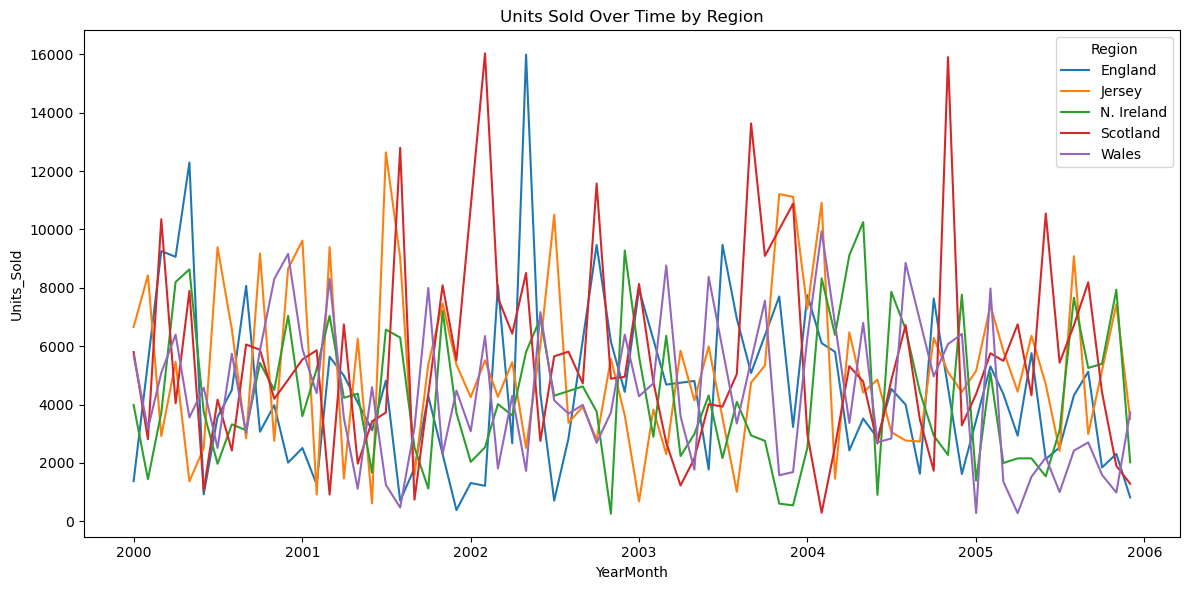

In [36]:
# 3. Units Sold Over Time (Line Plot)
units_by_month = df.groupby(["YearMonth", "Region"]).agg(
    Units_Sold=("Units Sold", "sum")
).reset_index()

units_by_month["YearMonth"] = pd.PeriodIndex(
    units_by_month["YearMonth"], freq="M"
).to_timestamp()

plt.figure(figsize=(12, 6))
sns.lineplot(
    data=units_by_month,
    x="YearMonth",
    y="Units_Sold",
    hue="Region"
)
plt.title("Units Sold Over Time by Region")
plt.tight_layout()
plt.show()


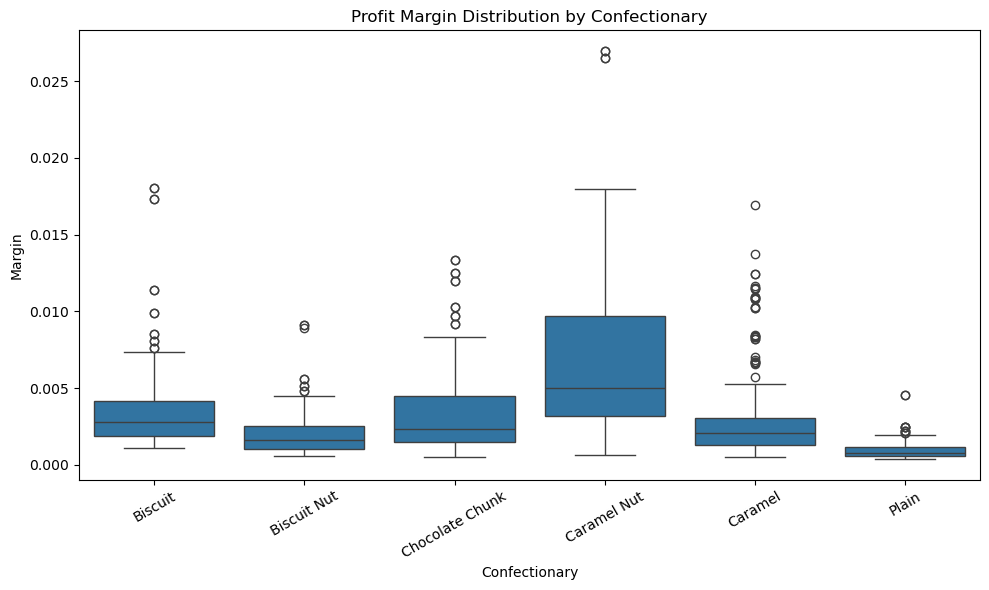

In [37]:
# 4. Profit Margin Distribution (Boxplot)
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=df,
    x="Confectionary",
    y="Margin"
)
plt.title("Profit Margin Distribution by Confectionary")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

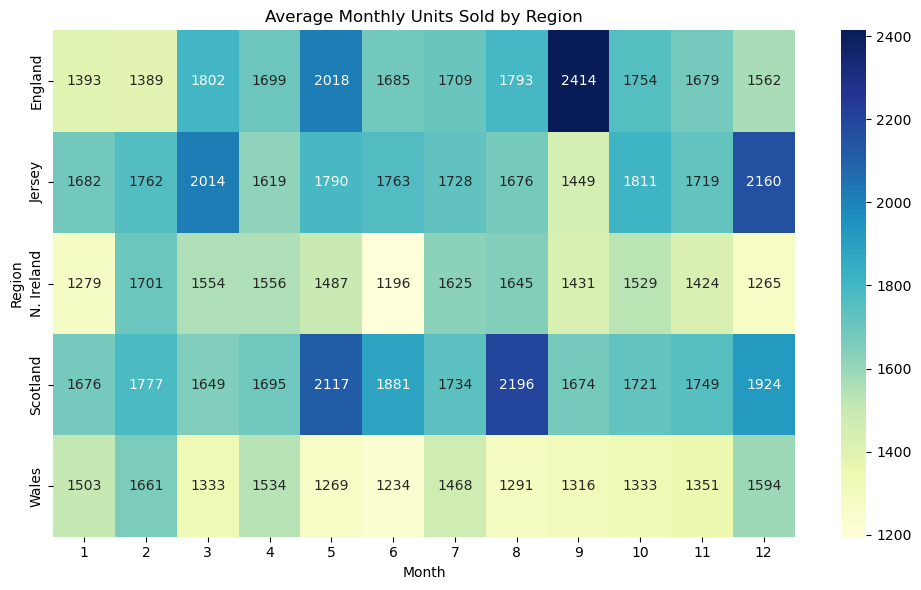

In [38]:
# 5. Monthly Units Sold Heatmap
pivot = df.groupby(["Region", "Month"]).agg(
    Avg_Units=("Units Sold", "mean")
).reset_index()

heatmap_data = pivot.pivot(index="Region", columns="Month", values="Avg_Units")

plt.figure(figsize=(10, 6))
sns.heatmap(
    heatmap_data,
    annot=True,
    fmt=".0f",
    cmap="YlGnBu"
)
plt.title("Average Monthly Units Sold by Region")
plt.tight_layout()
plt.show()

In [39]:
# ==========================================================
# INTERACTIVE DASHBOARD
# ==========================================================

app = Dash(__name__)
app.title = "Confectionary Dashboard"

regions = [{"label": r, "value": r} for r in sorted(df["Region"].unique())]
confs = [{"label": c, "value": c} for c in sorted(df["Confectionary"].unique())]

app.layout = html.Div([
    html.H2("Confectionary Dashboard"),
    html.Div([
        dcc.Dropdown(id="region-dd", options=regions, value=[regions[0]["value"]], multi=True),
        dcc.Dropdown(id="conf-dd", options=confs, value=[confs[0]["value"]], multi=True),
        dcc.RangeSlider(
            id="year-slider",
            min=int(df["Year"].min()), max=int(df["Year"].max()),
            value=[int(df["Year"].min()), int(df["Year"].max())],
            marks={int(y): str(int(y)) for y in sorted(df["Year"].dropna().unique())}
        )
    ], style={"marginBottom": "20px"}),

    html.Div(id="kpi-row", style={"display": "flex", "gap": "16px", "marginBottom": "16px"}),

    dcc.Tabs(id="tabs", value="tab-bar", children=[
        dcc.Tab(label="Margin Bar", value="tab-bar"),
        dcc.Tab(label="Units Over Time", value="tab-line"),
        dcc.Tab(label="Revenue vs Profit", value="tab-scatter"),
        dcc.Tab(label="Margin Boxplot", value="tab-box"),
        dcc.Tab(label="Monthly Heatmap", value="tab-heatmap"),
    ]),
    html.Div(id="tabs-content")
])

@app.callback(
    [Output("kpi-row", "children"), Output("tabs-content", "children")],
    [Input("tabs", "value"),
     Input("region-dd", "value"),
     Input("conf-dd", "value"),
     Input("year-slider", "value")]
)
def render_content(tab, sel_regions, sel_confs, year_range):
    y0, y1 = year_range
    sub = df[
        df["Region"].isin(sel_regions) &
        df["Confectionary"].isin(sel_confs) &
        df["Year"].between(y0, y1)
    ].copy()

    total_profit = sub["Profit(£)"].sum()
    total_revenue = sub["Revenue(£)"].sum()
    total_units = sub["Units Sold"].sum()
    avg_margin = sub["Margin"].mean()

    kpis = [
        html.Div([
            html.H4("Total Profit (£)"),
            html.P(f"{total_profit:,.0f}")
        ], style={"flex": "1", "padding": "10px", "border": "1px solid #ccc"}),

        html.Div([
            html.H4("Average Margin"),
            html.P(f"{avg_margin:.2%}")
        ], style={"flex": "1", "padding": "10px", "border": "1px solid #ccc"}),

        html.Div([
            html.H4("Total Revenue (£)"),
            html.P(f"{total_revenue:,.0f}")
        ], style={"flex": "1", "padding": "10px", "border": "1px solid #ccc"}),

        html.Div([
            html.H4("Total Units Sold"),
            html.P(f"{total_units:,.0f}")
        ], style={"flex": "1", "padding": "10px", "border": "1px solid #ccc"})
    ]

    if tab == "tab-bar":
        agg = sub.groupby(["Region", "Confectionary"]).agg(
            Revenue_Total=("Revenue(£)", "sum"),
            Profit_Total=("Profit(£)", "sum")
        ).reset_index()
        agg["Margin_Weighted"] = agg["Profit_Total"] / agg["Revenue_Total"]
        fig = px.bar(
            agg, x="Confectionary", y="Margin_Weighted",
            color="Region", barmode="group"
        )
        return kpis, dcc.Graph(figure=fig)

    if tab == "tab-line":
        units_by_month = sub.groupby(["YearMonth", "Region"]).agg(
            Units_Sold=("Units Sold", "sum")
        ).reset_index()
        fig = px.line(
            units_by_month, x="YearMonth", y="Units_Sold", color="Region"
        )
        return kpis, dcc.Graph(figure=fig)

    if tab == "tab-scatter":
        fig = px.scatter(
            sub, x="Revenue(£)", y="Profit(£)",
            color="Region", hover_data=["Confectionary"]
        )
        return kpis, dcc.Graph(figure=fig)

    if tab == "tab-box":
        fig = px.box(
            sub, x="Confectionary", y="Margin", color="Confectionary"
        )
        return kpis, dcc.Graph(figure=fig)

    if tab == "tab-heatmap":
        pivot = sub.groupby(["Region", "Month"]).agg(
            Avg_Units=("Units Sold", "mean")
        ).reset_index()
        fig = px.imshow(
            pivot.pivot(index="Region", columns="Month", values="Avg_Units")
        )
        return kpis, dcc.Graph(figure=fig)

    return kpis, html.Div("Select a tab.")

if __name__ == "__main__":
    app.run(debug=True, port=8066)